<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

### Notebook 2/3: Cleaning, Preprocessing and EDA

Notebook 1: Webscraping & exporting of datasets.<br>
Notebook 2: Cleaning, Preprocessing and EDA.<br>
Notebook 3: Model selection and fine tuning.

In [10]:
# Importing libraries needed for data cleaning and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import collections

from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
#from IPython.display import IFrame
from collections import Counter
#from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


import warnings
warnings.filterwarnings("ignore")

In [4]:
eb_full = pd.read_csv('../datasets/earbuds_full.csv')

In [5]:
hp_full = pd.read_csv('../datasets/headphones_full.csv')

### Preliminary EDA

Looking at the distribution of our features for both subreddits:

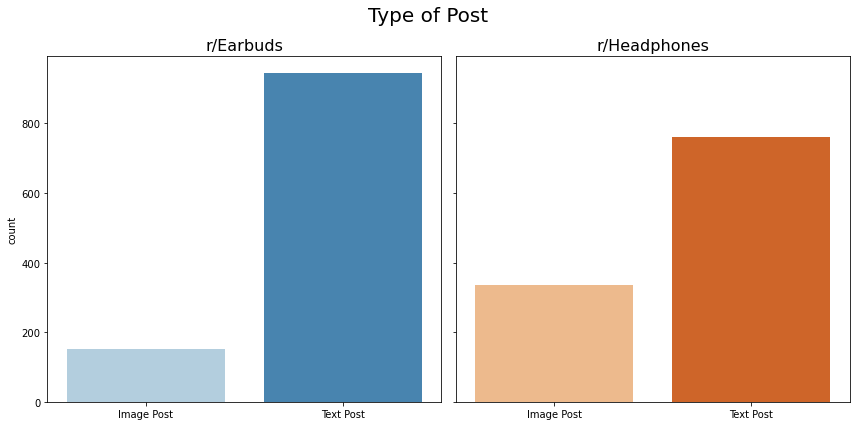

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
ax = ax.ravel()
g1 = sns.countplot(data=eb_full, x=eb_full['is_self'].astype(int), ax = ax[0], palette='Blues')
g1.set_xticklabels(['Image Post', 'Text Post'])
g1.set_title('r/Earbuds', fontsize=16)
g1.set_xlabel('')
g2 = sns.countplot(data=hp_full, x=hp_full['is_self'].astype(int), ax = ax[1], palette='Oranges')
g2.set_xticklabels(['Image Post', 'Text Post'])
g2.set_title('r/Headphones', fontsize=16)
g2.set_ylabel('')
g2.set_xlabel('')
plt.suptitle('Type of Post', fontsize=20)
plt.tight_layout()

It was noted that quite a number of posts in r/Headphones are not text posts. As we created a feature that combines both title text and post text (`post`), this shouldn't pose much of an issue to our model later on.

### Analyzing Title and Post Length

#### Title Length

In [43]:
def subplot_histograms(col, graph_title):
    fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
    ax = ax.ravel()
    
    # Plot first df   
    g1 = sns.histplot(data=eb_full, x=eb_full[col].str.len(), ax = ax[0], bins=25)
    mean_1 = eb_full[col].str.len().mean()
    ax[0].axvline(mean_1, ls='--', color='black')
    g1.set_title(f'r/Earbuds (Mean: {round(mean_1)} words)')
    g1.set_xlabel(f'Length of {col.capitalize()}')
    
    # Plot second df
    g2 = sns.histplot(data=hp_full, x=hp_full[col].str.len(), ax = ax[1], bins=25, color='darkorange')
    mean_2 = hp_full[col].str.len().mean()
    ax[1].axvline(mean_2, ls='--', color='black')
    g2.set_title(f'r/Headphones (Mean: {round(mean_2)} words)')
    g2.set_xlabel(f'Length of {col.capitalize()}')
    plt.suptitle(graph_title, fontsize=20)
    plt.tight_layout()


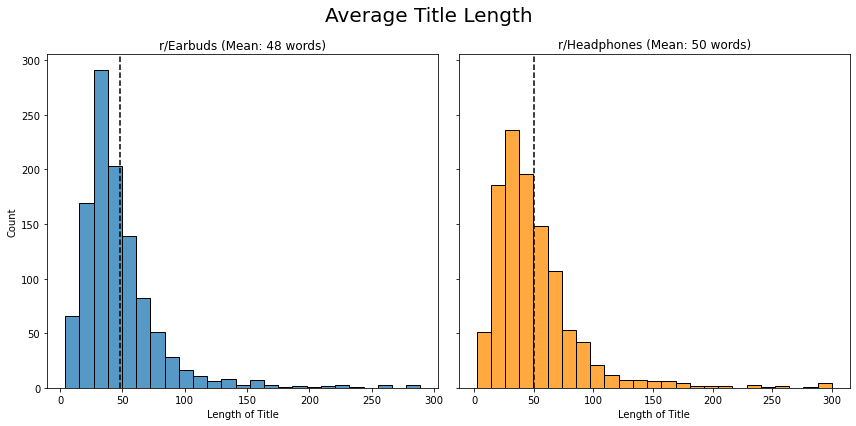

In [44]:
subplot_histograms('title', 'Average Title Length')

#### Post Length

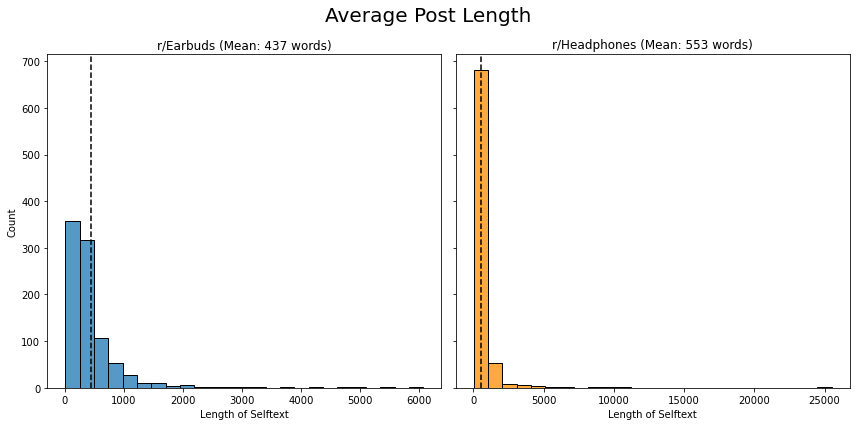

In [45]:
subplot_histograms('selftext', 'Average Post Length')

Noted that `r/Earbuds` generally has slightly shorter title and posts lengths than `r/Headphones`. 

We will now move on to data cleaning and processing, as well as analysis of Ngrams from each subreddit.

As the text we just gathered is unstructured data, we need to make sure that our text is clean and free of null values. This also entails removing HTML links and non-alphanumerical characters that won't be useful in a classification model.

### Data Cleaning and Preprocessing

In [15]:
# Function to get dataframe + preliminary cleaning
def get_df(df_full):
    # Get only the 3 focus columns
    df = df_full[['subreddit', 'title', 'selftext']]
    # Rename 'selftext' column to 'body':
    df.rename(columns = {'selftext': 'body'}, inplace = True)
    # View dataframe info
    #print(df.info())
    # Fill empty 'body' cells with 'title'
    df['body'].fillna(df['title'], inplace = True) 
    # Merge 'title' and 'body' of non-empty 'body' cells in new column
    df['post'] = df['title'] + " " + df['body']  
    # View new dataframe info
    #print(df.info())
    df = df[['subreddit', 'post']]
    return df

In [16]:
eb = get_df(eb_full)

In [17]:
hp = get_df(hp_full)

In [18]:
# Function to see how many words were in the body before cleaning the data.
def word_count(series):
    list_tokens = [w.lower() for w in series]
    string_tokens = str(list_tokens)
    tokens = BeautifulSoup(string_tokens).get_text()
    return tokens

In [19]:
len(word_count(eb['post']).split())

81176

In [20]:
len(word_count(hp['post']).split())

85735

The functions below removes HTML links, removing characters that are not letters, lower cases all the words, splits them up into individual tokens without officially tokenizing, removes the stopwords, and I tried both lemmatization and stemming the words . I commented out the stemmer because I ended up using the lemmatizer.

In [184]:
stop_words = stopwords.words('english')
extra_words = ['like', 'one', 'x', 'would', 'get', 'really', 'use', 'https', 'good', 'also', 'better', 'know', 
              'new', 'looking', 'removed', 'jpg', 'width', 'format', 'pjpg', 'xx', 'www', 'reddit', 'redd', 
              'preview', 'webp', 'view', 'poll', 'com', 'png']
stop_words.extend(extra_words)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
def status_words(status):
    '''takes a series and cleans the text data '''
    
    review_text = BeautifulSoup(status).get_text()
    # Removed HTML
    
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # Removed Non-letters
    
    words = letters_only.lower().split()
    # Tokenize without official tokenizer
    
    stops = set(stop_words)
    # Remove Stopwords
    
    meaningful_words = [lemmatizer.lemmatize(w) for w in words if w not in stops]
   # meaningful_words = [stemmer.stem(w) for w in words if w not in stops]
            # tried both the stemmer and the lemmatizer
    return(' '.join(meaningful_words))

In [185]:
# Add a column to the DataFrame
eb['post_clean'] = eb['post'].map(status_words)
hp['post_clean'] = hp['post'].map(status_words)

In [200]:
# Example to show the difference after processing the data
print(eb['post'][0])
print(eb['post_clean'][0])

Right earbud on Tozo NC9s won’t connect They connected fine until about a day ago when the left earbud stopped working and I have no idea how to fix it
right earbud tozo nc connect connected fine day ago left earbud stopped working idea fix


In [201]:
# Checking for null values after processing
eb.isnull().sum()[eb.isnull().sum() > 0], hp.isnull().sum()[hp.isnull().sum() > 0]

(Series([], dtype: int64), Series([], dtype: int64))

In [188]:
eb.shape, hp.shape

((1099, 3), (1099, 3))

A function was created to get the top n-grams from the two topics. `CountVectorizer` was used here. 

In [211]:
# Create function to get top tokens
def plot_top_tokens(df, col, n, n_gram_range, title, palette='tab10'):
    def get_top_n_tokens(corpus, n=n, k=n_gram_range):     
        vec = CountVectorizer(ngram_range=(k,k), stop_words = stop_words).fit(corpus)     
        bag_of_words = vec.transform(corpus)     
        sum_words = bag_of_words.sum(axis=0)      
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]    
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) 
        return words_freq[:n]
    temp_df = pd.DataFrame(data=get_top_n_words(df[col], n), columns=['word','freq'])
    plt.figure(figsize=(10,6))
    sns.barplot(data=temp_df, y='word', x='freq', palette=palette)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(title, fontsize=18)


### Top Words

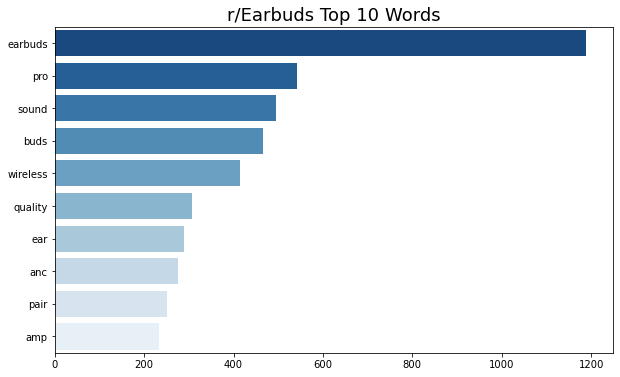

In [212]:
plot_top_words(eb,'post', 10, 1, 'r/Earbuds Top 10 Words', 'Blues_r')

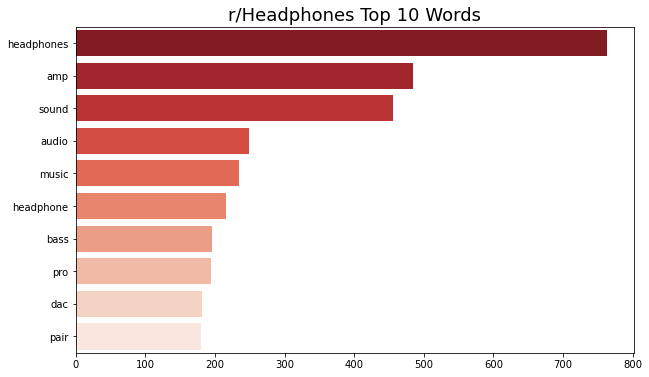

In [213]:
plot_top_words(hp,'post', 10, 1, 'r/Headphones Top 10 Words', 'Reds_r')

Note:
* anc = active noise cancellation
* amp = amplifier
* dac = digital to analogue converter

From the graphs above, we can observed that there are some overlap between the two topics. This is to be expected as the words are mostly general terms relating to audio (eg. `sound`). However, we can also see that even though there are some words that overlap, their standing among the top 10 words for each topic is different. For example, `amp` ranks as the 2nd top 10 words in `r/Headphones` but it only ranks 10th in `r/Earbuds`. In another example, `pro` ranks 2nd in `r/Earbuds` but ranks 8th in `r/Headphones`.  

### Top Bigrams

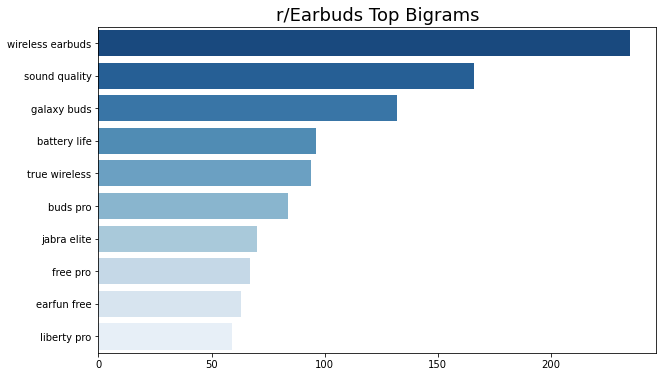

In [214]:
plot_top_words(eb,'post', 10, 2, 'r/Earbuds Top Bigrams', palette='Blues_r')

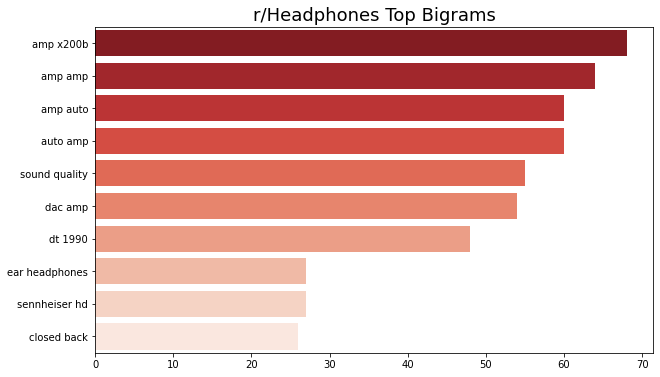

In [215]:
plot_top_words(hp,'post', 10, 2, 'r/Headphones Top Bigrams', palette='Reds_r')

At a quick glance, when comparing bigrams, we can see that the two topics have slightly more obvious differences. `r/Earbuds` shows more bigrams relating to earbud model names. There were 6 out of 10 bigrams relating to model names (`galaxy buds`, `buds pro`, `jabra elite`, `free pro`, `earfun free` and `liberty pro`). One of the top 10 words for `r/Earbuds` was also a bigram relating to specifications of earbuds: `battery life` and `true wireless`. These are features that are typically found in earbuds but not headphones. 

On the other hand, `r/Headphones` shows more bigrams relating to amplifiers. There were 5 out of 10 bigrams relating to amplifiers (`amp x 200b`, `amp auto`, `auto amp`, `dac amp` and `amp amp`). There were also some model names such as ` dt 1990` and `sennheiser hd`. There were also features that were specific to headphones such as `closed back`. Closed-back headphones are headphones that are completely sealed around the back, only allowing sound out where it can reach your ear. 

It was also noted there were quite a number of bigrams relating to imaging which were then added to the `stop_words` list. This was to be expected given that we know that there were a large number of image posts in `r/Headphones`.

There were still overlap noted that were related to general audio terms such as `sound quality`. 

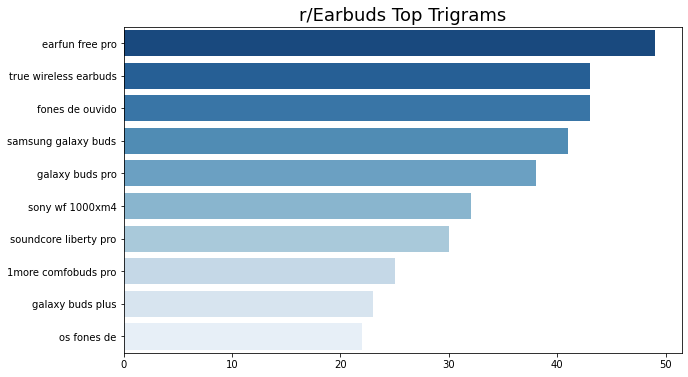

In [216]:
plot_top_words(eb, 'post', 10, 3, 'r/Earbuds Top Trigrams', 'Blues_r')

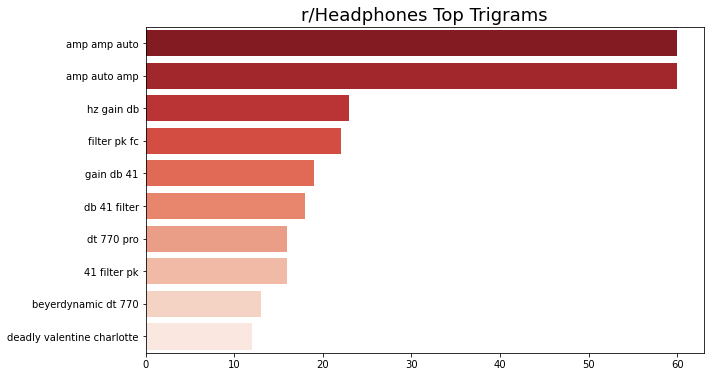

In [217]:
plot_top_words(hp,'post', 10, 3, 'r/Headphones Top Trigrams', palette='Reds_r')

There were some interesting things to note when looking at the trigrams of both topics. 

For `r/Earbuds`, 7 out of the top 10 trigrams were relating to model names (`earfun free pro`, `samsung galaxy buds`, `galaxy buds pro`, `sony wf 1000xm4`, `soundcore liberty pro`, `1more comfobuds pro` and `galaxy buds plus`). Once again, the same feature `true wireless earbuds` shows up in the top 10 trigrams here.

However, the most interesting thing to note here is that there are two trigrams (`fones de ouvido` and `os fones de`) which are in Portugese but a quick google search shows that these two trigrams can translate to either 'headphones' or 'earbuds'. It seems that in Portugese, there is no separate word for the two terms and its meaning can only be interpreted from the context in which its being used. 

When looking at the top 10 trigrams for `r/Headphones`, the 7 trigrams were relating to amplifiers and filters for headphones (`amp amp auto`, `amp auto amp`, `hz gain db`, `gain db 41`, `db 41 filter` and `41 filter pk`). There were 2 relating to model names (`dt 770 pro` and `beyerdynamic dt 770`). It was also interesting to note that the 10th trigram on the list is a song title "Deadly Valentine" by Charlotte Gainsbourg. a quick search shows that it seems like people have been using her song to test the audio quality of the headphones. 

### Combining data and setting target column

In [219]:
# Save and export cleaned data
eb.to_csv('../datasets/earbuds_clean.csv', index=None)
hp.to_csv('../datasets/headphones_clean.csv', index=None)

In [242]:
# Combine the 2 dataframes 
combined = pd.concat([eb, hp], axis=0)
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2198 entries, 0 to 1098
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subreddit   2198 non-null   object
 1   post        2198 non-null   object
 2   post_clean  2198 non-null   object
dtypes: object(3)
memory usage: 68.7+ KB


In [243]:
# Change subreddit to 0 for Earbuds and 1 for Headphones and rename column to 'is_headphones'
combined['subreddit'] = combined['subreddit'].map({'Earbuds': 0, 'headphones': 1})
combined.rename(columns = {'subreddit': 'is_headphones'}, inplace = True)

In [246]:
combined.shape

(2198, 3)

In [247]:
# Save and export combined data
combined.to_csv('../datasets/combined_clean.csv', index=None)